In [191]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score,classification_report
from sklearn.metrics import roc_curve, auc

# Time series decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Yahoo Finance
import yfinance as yf

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

In [192]:
# Split data into training/validation and test sets based on dates
start_date = '1900-01-31'
end_date = '2030-07-20'

In [228]:
df1 = pd.read_csv(file_path_1)
df2 = pd.read_csv(file_path_2)
df3 = pd.read_csv(file_path_3)

df1['date'] = pd.to_datetime(df['date']) # daily technical data
df2['datadate'] = pd.to_datetime(df2['datadate'])  # Fundamental data
df3['qdate'] = pd.to_datetime(df3['qdate'])  # Financial ratios data

# Sort by qdate and public_date to ensure the most recent public_date comes last
df3 = df3.sort_values(by=['qdate', 'public_date'])
# Drop duplicates to keep only the latest public_date for each qdate
df3 = df3.drop_duplicates(subset='qdate', keep='last')

df_fundamental = pd.merge_asof(
    df2,  # Daily data sorted by date
    df3,  # Fundamental data sorted by quarterly date
    left_on='datadate', right_on='qdate',  # Merge on dates
    direction='backward'  # Merge to the closest past quarter
)

df1_quarterly = df1.set_index('date').resample('Q').last().reset_index()
df1_quarterly = df1_quarterly[['date', 'PRC']]

df_fundamental = pd.merge_asof(
    df1_quarterly,  # Daily data sorted by date
    df_fundamental,  # Fundamental data sorted by quarterly date
    left_on='date', right_on='datadate',  # Merge on dates
    direction='backward'  # Merge to the closest past quarter
)

features = ['PRC', 'epsfxq', 'ltq', 'niq', 'revtq', 'capxy', 'npm', 'de_ratio', 'curr_ratio', 'ptb']

feature_renames = {
    'epsfxq': 'earnings_per_share', 
    'ltq': 'total_liabilities', 
    'niq': 'net_income', 
    'revtq': 'revenue', 
    'capxy': 'capital_expenditures', 
    'npm': 'net_profit_margin', 
    'de_ratio': 'debt_equity_ratio', 
    'curr_ratio': 'current_ratio', 
    'ptb': 'price_to_book_ratio'
}

df_fundamental = df_fundamental[(df_fundamental['date'] >= start_date) & (df_fundamental['date'] <= end_date)].copy()
#df_fundamental[features] = df_fundamental[features].pct_change()
df_fundamental = df_fundamental[['date'] + features].rename(columns=feature_renames)
df_fundamental['pe_ratio'] = df_fundamental['PRC'] / df_fundamental['earnings_per_share']
df_fundamental['book_value'] = df_fundamental['PRC'] / df_fundamental['price_to_book_ratio']
df_fundamental = df_fundamental.dropna()
df_fundamental.index = range(len(df_fundamental))

df_fundamental.tail()

date     PRC  earnings_per_share  total_liabilities  net_income  \
116 2022-12-31  79.000                3.09           166594.0     12750.0   
117 2023-03-31  74.750                2.79           162957.0     11430.0   
118 2023-06-30  80.375                1.94           156251.0      7880.0   
119 2023-09-30  73.750                2.25           164726.0      9070.0   
120 2023-12-31  74.875                1.91           163779.0      7630.0   

     revenue  capital_expenditures  net_profit_margin  debt_equity_ratio  \
116  93164.0               18407.0              0.140              0.854   
117  83644.0                5412.0              0.156              0.911   
118  80795.0               10771.0              0.142              0.851   
119  88570.0               15691.0              0.119              0.821   
120  81688.0               21919.0              0.119              0.821   

     current_ratio  price_to_book_ratio   pe_ratio  book_value  
116          1.414                2.211  25.566343   35.730439  
117          1.336                1.954  26.792115   38.254862  
118          1.421                1.885  41.430412   42.639257  
119          1.443                1.791  32.777778   41.178113  
120          1.443                1.791  39.201571   41.806253

In [194]:
df = pd.read_csv(file_path_1)

df['date'] = pd.to_datetime(df['date'])  # CRSP daily data
df = df[(df['date'] >= start_date) & (df['date'] <= end_date)].copy()
df.index = range(len(df))

fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Ohlc(x=df.date,
                      open=df.OPENPRC,
                      high=df.ASKHI,
                      low=df.BIDLO,
                      close=df.PRC,
                      name='Price'), row=1, col=1)

fig.add_trace(go.Scatter(x=df.date, y=df.VOL, name='Volume'), row=2, col=1)

fig.update(layout_xaxis_rangeslider_visible=False)
fig.show()

In [222]:
xom = yf.Ticker('XOM')

# Get quarterly balance sheet
balance_sheet = xom.quarterly_balance_sheet

# Extract the balance sheet for the specific quarter
balance_sheet = balance_sheet['2023-09-30']

keywords = ['Total Revenue', 'Capital Expenditures']  # Adjust names if needed
filtered_data = balance_sheet.loc[balance_sheet.index.intersection(keywords)]

# Print the filtered data
print(balance_sheet)

balance_sheet.to_csv('xom_revenue_capex.csv')



Treasury Shares Number                                          4056000000.0
Ordinary Shares Number                                          3962917886.0
Share Issued                                                    8018917886.0
Net Debt                                                        8309000000.0
Total Debt                                                     41253000000.0
Tangible Book Value                                           199703000000.0
Invested Capital                                              240956000000.0
Working Capital                                                29956000000.0
Net Tangible Assets                                           199703000000.0
Capital Lease Obligations                                                NaN
Common Stock Equity                                           199703000000.0
Total Capitalization                                          236213000000.0
Total Equity Gross Minority Interest                          207533000000.0

In [195]:
horizon = 30

# Define the target variable directly
df['target'] = (df['PRC'].shift(-horizon) > df['PRC']).astype(int)

# Drop NaNs resulting from the shift
df = df.dropna()
df.index = range(len(df))  # Reset index

df.tail()

#print(len(df))


PERMNO       date TICKER    BIDLO   ASKHI     PRC         VOL  \
7939   11850 2023-12-22    XOM  101.820  102.94  101.91  12927831.0   
7940   11850 2023-12-26    XOM  102.115  103.03  102.14  16835144.0   
7941   11850 2023-12-27    XOM  101.335  102.55  101.66  14558830.0   
7942   11850 2023-12-28    XOM  100.130  101.61  100.19  16329252.0   
7943   11850 2023-12-29    XOM   99.620  100.59   99.98  17746408.0   

            RET  OPENPRC  target  
7939   0.001769   102.31       0  
7940   0.002257   102.74       0  
7941  -0.004699   102.04       0  
7942  -0.014460   101.39       0  
7943  -0.002096   100.37       0

In [196]:
test_size  = 0.15
valid_size = 0.15

test_split_idx  = int(df.shape[0] * (1-test_size))
valid_split_idx = int(df.shape[0] * (1-(valid_size+test_size)))

train_df  = df.loc[:valid_split_idx].copy()
valid_df  = df.loc[valid_split_idx+1:test_split_idx].copy()
test_df   = df.loc[test_split_idx+1:].copy()

#Ony keep the last day of each month
#test_df = test_df.loc[df.groupby(test_df['date'].dt.to_period('M'))['date'].idxmax()]
#test_df['target'] = (test_df['PRC'].shift(-1) > test_df['PRC']).astype(int)

df.head(10)

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df.date, y=train_df.PRC, name='Training'))
fig.add_trace(go.Scatter(x=valid_df.date, y=valid_df.PRC, name='Validation'))
fig.add_trace(go.Scatter(x=test_df.date,  y=test_df.PRC,  name='Test'))
fig.show()

# save test dates
test_dates = test_df['date']

In [197]:
drop_cols = ['date', 'VOL', 'BIDLO', 'ASKHI', 'RET', 'OPENPRC', 'TICKER', 'PERMNO']

train_df = train_df.drop(drop_cols, 1)
valid_df = valid_df.drop(drop_cols, 1)
test_df  = test_df.drop(drop_cols, 1)

train_df.head()

PRC  target
0  62.125       0
1  62.125       0
2  62.125       1
3  61.375       1
4  62.375       1

In [198]:
y_train = train_df['target'].copy()
X_train = train_df.drop(['target',], 1)

y_valid = valid_df['target'].copy()
X_valid = valid_df.drop(['target',], 1)

y_test  = test_df['target'].copy()
X_test  = test_df.drop(['target',], 1)

X_train.head()

PRC
0  62.125
1  62.125
2  62.125
3  61.375
4  62.375

In [199]:
# Scaling
scaler = MinMaxScaler()

# Fit the scaler on the training/validation data
X_train_scaled = scaler.fit_transform(X_train)

# Now apply the same scaling to the val/test data using the already fitted scaler
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

# Convert the scaled data back to DataFrame for consistency
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_valid_scaled = pd.DataFrame(X_valid_scaled, columns=X_valid.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

X_train_scaled.head(90)

PRC
0   0.402693
1   0.402693
2   0.402693
3   0.393212
4   0.405853
..       ...
85  0.402693
86  0.410594
87  0.415334
88  0.416914
89  0.409013

[90 rows x 1 columns]

In [200]:


%%time

parameters = {
    'n_estimators': [300],
    'learning_rate': [0.05],
    'max_depth': [8],
    'gamma': [0.00001],
    'random_state': [42]
}

eval_set = [(X_train_scaled, y_train), (X_valid_scaled, y_valid)]
model = xgb.XGBClassifier(eval_set=eval_set, objective='binary:logistic', verbose=False)
clf = GridSearchCV(model, parameters)

clf.fit(X_train_scaled, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')



/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[21:26:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_set", "verbose" } are not used.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[21:26:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_set", "verbose" } are not used.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[21:26:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_set", "verbose" } are not used.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[21:26:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_set", "verbose" } are not used.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[21:26:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { 

Best params: {'gamma': 1e-05, 'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 300, 'random_state': 42}
Best validation score = 0.5560152417149838
CPU times: user 14.3 s, sys: 890 ms, total: 15.2 s
Wall time: 2.92 s


In [201]:
%%time

model = xgb.XGBClassifier(**clf.best_params_, objective='binary:logistic')
model.fit(X_train_scaled, y_train, eval_set=eval_set, verbose=False)

CPU times: user 3.08 s, sys: 151 ms, total: 3.23 s
Wall time: 513 ms


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1e-05, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

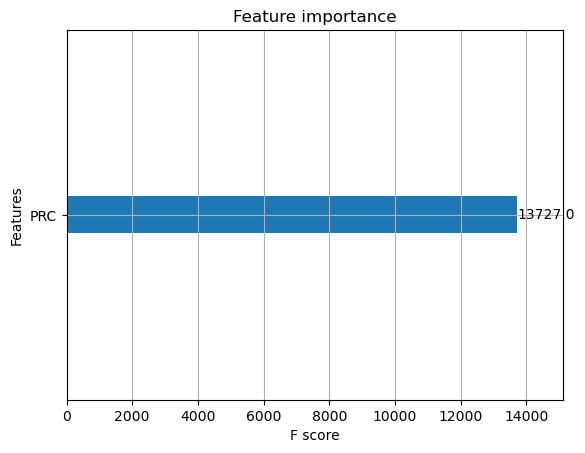

In [202]:
plot_importance(model);

In [203]:
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]  # Selecting only the positive class probability

test_df['y_pred'] = y_pred
test_df['y_pred_proba'] = y_pred_proba
test_df['date'] = test_dates

# Classification report
classification_report_data = classification_report(y_test, y_pred)
# Print the classification report
print(classification_report_data)


# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
print(roc_auc)

# Create interactive Plotly figure
fig = go.Figure()

# Add ROC curve
fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name=f'ROC curve (AUC = {roc_auc:.2f})',
                         line=dict(color='blue', width=2)))

# Add diagonal reference line
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Random Guess',
                         line=dict(color='gray', dash='dash')))

# Add "Ideal Classifier" line
fig.add_trace(go.Scatter(
    x=[0, 0, 1], y=[0, 1, 1], mode='lines', 
    name='Ideal Classifier',
    line=dict(color='green', dash='dash')
))

# Layout settings
fig.update_layout(title="Receiver Operating Characteristic (ROC) Curve",
                  xaxis_title="False Positive Rate",
                  yaxis_title="True Positive Rate",
                  xaxis=dict(range=[0,1]),
                  yaxis=dict(range=[0,1.05]),
                  template="plotly_white")

# Show interactive plot
fig.show()


#test_df.head()

              precision    recall  f1-score   support

           0       0.53      0.45      0.49       561
           1       0.57      0.65      0.61       630

    accuracy                           0.55      1191
   macro avg       0.55      0.55      0.55      1191
weighted avg       0.55      0.55      0.55      1191

0.5916659593130181


In [204]:
test_df_monthly = test_df.loc[df.groupby(test_df['date'].dt.to_period('M'))['date'].idxmax()]
buys = test_df_monthly[test_df_monthly['y_pred'] == 1]
sells = test_df_monthly[test_df_monthly['y_pred'] == 0]

fig = go.Figure()
fig.add_trace(go.Scatter(x=test_df.date,  y=test_df.PRC,  name='Test'))

# Add Green Up Arrows for most certain class 1 predictions
fig.add_trace(go.Scatter(
    x=buys.date, 
    y=buys.PRC,
    mode='markers',
    marker=dict(color='green', size=15, symbol='triangle-up'),
))

# Add Red Down Arrows for most certain class 0 predictions
fig.add_trace(go.Scatter(
    x=sells.date, 
    y=sells.PRC,
    mode='markers',
    marker=dict(color='red', size=15, symbol='triangle-down'),
))

fig.update_layout(
    height=600  # Adjust height (default is ~450-500)
)

fig.show()
